In [1]:
import os
import glob
import numpy as np
from PIL import Image
from scipy import misc
from scipy import io
import matplotlib.pyplot as plt
import math
import tables
import tensorflow as tf
import time

%matplotlib inline

In [2]:
trimgpath = 'D://Windows/Downloads/University/Senior/KIOST/test1/testimg.mat'
trlabpath = 'D://Windows/Downloads/University/Senior/KIOST/test1/testlabel.mat'
teimgpath = 'D://Windows/Downloads/University/Senior/KIOST/test1/testimg2.mat'
telabpath = 'D://Windows/Downloads/University/Senior/KIOST/test1/testlabel2.mat'

In [3]:
trimgmat = io.loadmat(trimgpath)
trlabmat = io.loadmat(trlabpath)
teimgmat = io.loadmat(teimgpath)
telabmat = io.loadmat(telabpath)

In [4]:
trainimg   = trimgmat['testimage']
trainlabel = trlabmat['testlabel']
testimg    = teimgmat['testimage2']
testlabel   = telabmat['testlabel2']

In [5]:
print(trainimg.shape)
print(trainlabel.shape)
print(testimg.shape)
print(testlabel.shape)


(35721, 7)
(35721, 2)
(63001, 7)
(63001, 2)


In [6]:
size = int(math.sqrt(testimg.shape[0]))
print (size)

251


In [7]:
test0 = testimg[:,0]


In [8]:
test0 = np.reshape(test0, [size, size])
teest0 = np.transpose(test0)

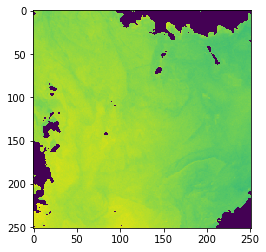

In [9]:
plt.imshow(test0)

In [10]:
def MLP(x):
    
    w1 = tf.Variable(tf.truncated_normal([7, 64], stddev = math.sqrt(2/7)))
    b1 = tf.Variable(tf.constant(0.1, shape=[1, 64]))
    act1 = tf.nn.relu(tf.add(tf.matmul(x, w1),b1))
    
    w2 = tf.Variable(tf.truncated_normal([64, 32], stddev = math.sqrt(2/64)))
    b2 = tf.Variable(tf.constant(0.1, shape=[1, 32]))
    act2 = tf.nn.relu(tf.add(tf.matmul(act1, w2),b2))
    
    w3 = tf.Variable(tf.truncated_normal([32, 2], stddev = math.sqrt(2/32)))
    b3 = tf.Variable(tf.constant(0.1, shape=[1, 2]))
    act3 = tf.nn.relu(tf.add(tf.matmul(act2, w3),b3))
    
    return act3

In [11]:
x = tf.placeholder(tf.float32, [None, 7])

y = tf.placeholder(tf.float32, [None, 2])

In [12]:
learning_rate = 0.001

pred = MLP(x)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))

train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [13]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())



In [14]:
saver = tf.train.Saver()

In [21]:
learning_rate = 0.01
Loopstart = time.time()

for step in range(1000):
    avg_cost = 0.
    num_batch = int(trainimg.shape[0]/500)
    #Stepstart = time.time()
    
    for i in range(num_batch):
        randidx = np.random.randint(trainimg.shape[0], size=500)
        randidx.sort()
        batch_trimg = trainimg[randidx, :]
        batch_trlab = trainlabel[randidx, :]
        sess.run(train_step, feed_dict = {x:batch_trimg, y:batch_trlab})
        avg_cost += sess.run(cross_entropy, feed_dict = {x:batch_trimg, y:batch_trlab})
    
    
    if (step+1)%200 ==0:
        print (step + 1)
        print ("cost = ", avg_cost)
        train_acc = sess.run(accuracy, feed_dict={x: batch_trimg, y: batch_trlab})
        print ('Training Accuracy : ', train_acc)
        test_acc = train_acc = sess.run(accuracy, feed_dict={x: testimg, y: testlabel})
        print ('Test Accuracy : ', test_acc)
        saver.save(sess, 'D://Windows/Downloads/University/Senior/KIOST/test1/2label/mymodel', global_step=step)
        #print ('Step Time : ',(time.time() - Stepstart)/60,'m','\n' )
        
        
print ('Training Done')
print ('Loop Time : ', (time.time() - Loopstart)/60,'m' )   

200
cost =  5.5846302174
Training Accuracy :  0.966
Test Accuracy :  0.938493
400
cost =  5.2422311455
Training Accuracy :  0.972
Test Accuracy :  0.938493
600
cost =  5.59344160184
Training Accuracy :  0.956
Test Accuracy :  0.938493
800
cost =  5.56281753629
Training Accuracy :  0.96
Test Accuracy :  0.938493
1000
cost =  5.47511636093
Training Accuracy :  0.966
Test Accuracy :  0.938493
Training Done
Loop Time :  4.571030330657959 m


In [22]:
classifyimg = [testimg, testlabel]
classify = sess.run(pred, feed_dict={x:classifyimg[0]})
result = np.argmax(classify,1)
recon = np.reshape(result, [251, 251])

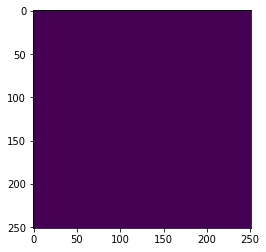

In [23]:
plt.imshow(recon)
plt.show()

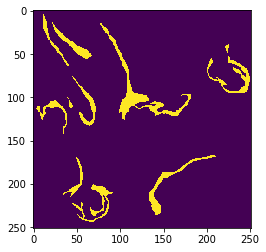

In [24]:
plt.imshow(np.reshape(classifyimg[1][:,1], [251, 251]))

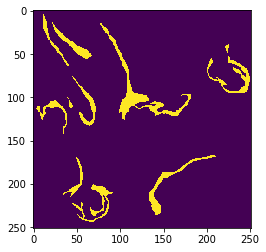

In [25]:

plt.imshow(np.reshape(classifyimg[1][:,1], [251, 251]) - (0.5*recon))
plt.show()

# 노랑 : 적조인데 못맞춘 부분 (1)
# 초록: 적조를 맞춘 부분 (0.5)
# 보라 : 적조라고 잘못판단한 부분 (-0.5)
# 청록 : 적조가 아니라고 맞춘 부분 (0)

In [26]:
error = classifyimg[1][:,1] - (0.5*result)

error=list(error)

eblue = error.count(0)

eyello = error.count(1)

emagenta = error.count(-0.5)

egreen = error.count(0.5)


lyello = list(classifyimg[1][:,1]).count(1)

lmagenta = list(classifyimg[1][:,1]).count(0)

red_acc = egreen/lyello*100
no_acc = eblue/lmagenta*100
red_error = eyello/lyello*100
no_error = emagenta/lmagenta*100
print ('Red tide acc : ', red_acc,"%")
print ('No acc : ', no_acc,"%")
print ('Red tide error : ', red_error,"%")
print ('No error : ', no_error,"%")

Red tide acc :  0.0 %
No acc :  100.0 %
Red tide error :  100.0 %
No error :  0.0 %


In [88]:
lmagenta

59126